# Compositional Pattern Producing Network (CPPN)


## Part 1: Overview

The Compositional Pattern Producing Network (CPPN) is an indirect encoding method used to generate the morphology of modular robot bodies in ARIEL. It relies on the NEAT (NeuroEvolution of Augmenting Topologies) algorithm to evolve the topology and weights of a network.

Unlike vector-based encodings (like NDE), the CPPN operates as a function over coordinate space. By passing spatial coordinates and distances into the network, it outputs probabilities that determine:

1. Whether a module exists at a given coordinate.
2. The type of the module (e.g., hinge or brick).
3. The rotation of the module relative to its parent (45°, 90°, 135°, 180°, or 225°).

The evolvable genotype is represented as a directed graph of nodes and connections (genes) with associated weights and innovation numbers. For ease of storage and manipulation within evolutionary algorithms, the Genome object can be seamlessly converted to and from a standard Python dictionary.

## Part 2: Implementation

Needed Imports

In [13]:
# CPPN Genotype imports
from ariel.body_phenotypes.robogen_lite.cppn_neat.genome import Genome
from ariel.body_phenotypes.robogen_lite.cppn_neat.id_manager import IdManager
from ariel.body_phenotypes.robogen_lite.config import NUM_OF_ROTATIONS, NUM_OF_TYPES_OF_MODULES

# Decoding imports
from ariel.body_phenotypes.robogen_lite.decoders.cppn_best_first import MorphologyDecoderBestFirst
from ariel.body_phenotypes.robogen_lite.constructor import construct_mjspec_from_graph

# Robot visualisation
from ariel.simulation.environments import SimpleFlatWorld
from ariel.utils.renderers import single_frame_renderer
import mujoco as mj

### Initialisation
The CPPN requires an IdManager to track structural mutations (innovation numbers and node IDs) across the population. We also must define the number of inputs and outputs for the network.

In [14]:
# Define network dimensions based on module types and possible rotations
T = NUM_OF_TYPES_OF_MODULES
R = NUM_OF_ROTATIONS

NUM_CPPN_INPUTS = 6
NUM_CPPN_OUTPUTS = 1 + T + R

# Initialise the ID Manager for NEAT tracking
id_manager = IdManager(
    node_start=NUM_CPPN_INPUTS + NUM_CPPN_OUTPUTS - 1,
    innov_start=(NUM_CPPN_INPUTS * NUM_CPPN_OUTPUTS) - 1,
)

# Define the maximum number of modules the robot is allowed to have
num_modules = 10

### Generate Random Genotype
Because CPPNs rely on complex topologies rather than flat arrays, we generate the initial random genotype using the Genome class, passing in our tracked IDs.

In [15]:
# Generate a random CPPN Genome
cppn_genome = Genome.random(
    num_inputs=NUM_CPPN_INPUTS,
    num_outputs=NUM_CPPN_OUTPUTS,
    next_node_id=id_manager.get_next_node_id(),
    next_innov_id=id_manager.get_next_innov_id(),
)

# Genotypes can be converted to dictionaries for saving to databases
genome_dict = cppn_genome.to_dict()
print(f"Nodes: {len(genome_dict['nodes'])}, Connections: {len(genome_dict['connections'])}")

Nodes: 19, Connections: 78


### Mutating the Genotype (Optional EC operator)
Because CPPNs evolve both weights and structure, mutation requires access to the id_manager.

In [16]:
# Mutate weights and structure
weight_mutation_rate = 0.8
structural_mutation_rate = 0.5

cppn_genome.mutate(
    weight_mutation_rate,
    structural_mutation_rate,
    id_manager.get_next_innov_id,
    id_manager.get_next_node_id,
)

## Part 3: Robot Graph
To turn the CPPN network into a physical robot, we must decode it into a graph. For CPPNs, ARIEL uses the MorphologyDecoderBestFirst, which queries the network to iteratively construct the robot module by module up to the maximum limit.

In [17]:
def genome_to_robot(genome, max_modules):
    """Create mujoco specification from CPPN genome"""
    
    # Check for topological validity (resolves cyclical references)
    genome.get_node_ordering()
    
    # Decode the genome into a graph using Best-First logic
    decoder = MorphologyDecoderBestFirst(
        cppn_genome=genome, 
        max_modules=max_modules
    )
    robot_graph = decoder.decode()
    
    # Failsafe if the CPPN generated an empty body
    if robot_graph.number_of_nodes() == 0:
        return None

    robot_spec = construct_mjspec_from_graph(robot_graph)
    return robot_spec.spec

robot_spec = genome_to_robot(cppn_genome, num_modules)

### Spawn robot in simulation
Now that we have the robot specification (which is standardized regardless of whether it came from NDE or CPPN), we can spawn the robot in a world and visualise it.

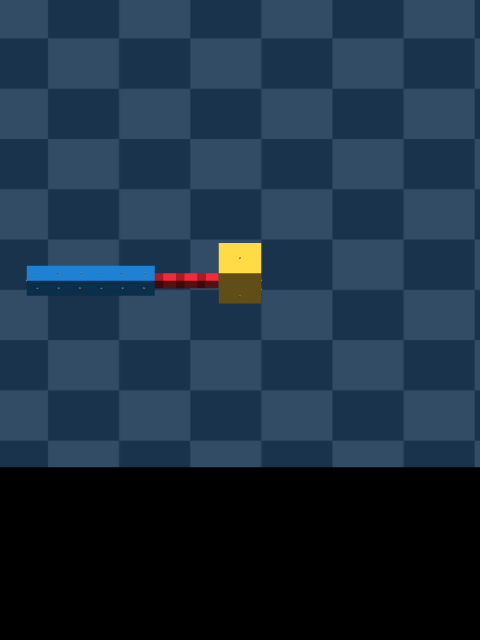

In [18]:

# Initialise the world you want to spawn the robot in
world = SimpleFlatWorld()

# Spawn the robot
world.spawn(robot_spec)

# Initialise mujoco model and data
model = world.spec.compile()
data = mj.MjData(model)

# Render a frame of the robot
# Zoomed in for better viewing
single_frame_renderer(model, 
                        data,
                        cam_fovy=3,
                        cam_pos=[-0.7,    # x pos
                                0.1,     # y pos
                                0.5],    # z pos
                        )
